# Higgs Boson Analysis with CMS Open Data
This is an example analysis of the Higgs boson detection via the decay channel H &rarr; ZZ* &rarr; 4l  
From the decay products measured at the CMS experiment and provided as open data, you will be able to produce a histogram, and from there you can infer the invariant mass of the Higgs boson.  
Code: it is based on the original work on [cms opendata notebooks](https://github.com/cms-opendata-analyses/HiggsExample20112012) and this [derived work](https://root.cern/doc/master/df103__NanoAODHiggsAnalysis_8py.html)  
Reference: link to the [original article with CMS Higgs boson discovery](https://inspirehep.net/record/1124338)

See also: https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

Author and contact: Luca.Canali@cern.ch  
April, 2022

## Monte Carlo signal data for the H &rarr; ZZ* &rarr; 4l analsys 

In [1]:
# Run this if you need to install Apache Spark (PySpark)

# !pip install pyspark

In [ ]:
# Start the Spark Session
# This uses local mode for simplicity
# the use of findspark is optional

import findspark
findspark.init("/home/luca/Spark/spark-3.4.0-SNAPSHOT-bin-20220425")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("H_ZZ_4Lep")
         .master("local[*]")
         .config("spark.driver.memory", "8g")
         .config("spark.sql.parquet.enableNestedColumnVectorizedReader", "true")
         .getOrCreate()
        )

In [ ]:
# Run this to download the dataset 
# It is a small file (200 KB), this exercise is meant mostly to show the Spark API
# See further details at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

!wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/CMS_Higgs_opendata/SMHiggsToZZTo4L.parquet


In [2]:
# Read data with the candidate events

df_events = spark.read.parquet("SMHiggsToZZTo4L.parquet")

df_events.printSchema()


root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: long (nullable = true)
 |-- event: decimal(20,0) (nullable = true)
 |-- PV_npvs: integer (nullable = true)
 |-- PV_x: float (nullable = true)
 |-- PV_y: float (nullable = true)
 |-- PV_z: float (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Muon_pfRelIso03_all: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_pfRelIso04_all: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_tightId: array (nullable = true)
 |    |-- element:

In [3]:
# Count the number of events before cuts (filter)
print(f"Number of events: {df_events.count()}")

Number of events: 299973


### Apply basic cuts
More details on the cuts (filters applied to the event data) in the reference ATLAS paper on the [discovery of the Higgs boson](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1) 

In [4]:
# Apply filters to the input data
# only events with 4 muons in the input data
df_events_4muons = df_events.filter("nMuon == 4")

# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
df_events_4muons = df_events_4muons.filter("Muon_charge[0] + Muon_charge[1] + Muon_charge[2] + Muon_charge[3] == 0")

print(f"Number of events after applying cuts: {df_events_4muons.count()}")

Number of events after applying cuts: 20525


### Compute the invariant mass
This computes the 4-vectors sum for the 4-lepton system
using formulas from special relativity.  
See also http://edu.itp.phys.ethz.ch/hs10/ppp1/2010_11_02.pdf
and https://en.wikipedia.org/wiki/Invariant_mass

In [5]:
# This computes the 4-vectors sum for the 4-muon system

# convert to cartesian coordinates
df_4lep = df_events_4muons.selectExpr(
"Muon_pt[0] * cos(Muon_phi[0]) P0x", "Muon_pt[1] * cos(Muon_phi[1]) P1x", "Muon_pt[2] * cos(Muon_phi[2]) P2x", "Muon_pt[3] * cos(Muon_phi[3]) P3x",
"Muon_pt[0] * sin(Muon_phi[0]) P0y", "Muon_pt[1] * sin(Muon_phi[1]) P1y", "Muon_pt[2] * sin(Muon_phi[2]) P2y", "Muon_pt[3] * sin(Muon_phi[3]) P3y",
"Muon_pt[0] * sinh(Muon_eta[0]) P0z", "Muon_pt[1] * sinh(Muon_eta[1]) P1z", "Muon_pt[2] * sinh(Muon_eta[2]) P2z", "Muon_pt[3] * sinh(Muon_eta[3]) P3z",
"Muon_mass[0] as Mass"
)


# compute energy for each muon
df_4lep = df_4lep.selectExpr(
 "P0x", "P0y", "P0z", "sqrt(Mass* Mass + P0x*P0x + P0y*P0y + P0z*P0z) as E0",
 "P1x", "P1y", "P1z", "sqrt(Mass* Mass + P1x*P1x + P1y*P1y + P1z*P1z) as E1",
 "P2x", "P2y", "P2z", "sqrt(Mass* Mass + P2x*P2x + P2y*P2y + P2z*P2z) as E2",
 "P3x", "P3y", "P3z", "sqrt(Mass* Mass + P3x*P3x + P3y*P3y + P3z*P3z) as E3"
)

# sum energy and momenta over the 4 muons
df_4lep = df_4lep.selectExpr(
 "P0x + P1x + P2x + P3x as Px",
 "P0y + P1y + P2y + P3y as Py",
 "P0z + P1z + P2z + P3z as Pz",
 "E0 + E1 + E2 + E3 as E"
)

df_4lep.show(5)

+-------------------+-------------------+------------------+------------------+
|                 Px|                 Py|                Pz|                 E|
+-------------------+-------------------+------------------+------------------+
| 1.9872338393944102|-40.808237156749605|-132.5899631961392|  179.176589316332|
| 22.661705611756854| 13.587090233397214|-76.61472199308764|147.16164198962448|
|-27.517601024367103|  -95.9115300600873| 64.09032110424545|171.83558355242639|
| 16.191153610095057|  25.97833152139165| 33.19459329369197|  61.2889389115059|
|-31.820404279871955|  6.468262098449042|-246.5480258533116| 278.6100202584995|
+-------------------+-------------------+------------------+------------------+
only showing top 5 rows



In [6]:
# This computes the invariant mass for the 4-muon system

df_4lep_invmass = df_4lep.selectExpr("sqrt(E * E - ( Px * Px + Py * Py + Pz * Pz)) as invmass_GeV")

df_4lep_invmass.show(5)

+------------------+
|       invmass_GeV|
+------------------+
| 113.3794095085435|
|122.83554585200446|
|124.35295955848554|
|41.441836893454145|
|125.63135672740138|
+------------------+
only showing top 5 rows



In [7]:
# Compute the histogram of invariant mass
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)

min_val = 80
max_val = 180
num_bins = (max_val - min_val) / 5.0
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_4lep_invmass
        .selectExpr(f"width_bucket(invmass_GeV, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding center value of the histogram
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")

In [8]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 266 ms, sys: 34 ms, total: 300 ms
Wall time: 1.38 s


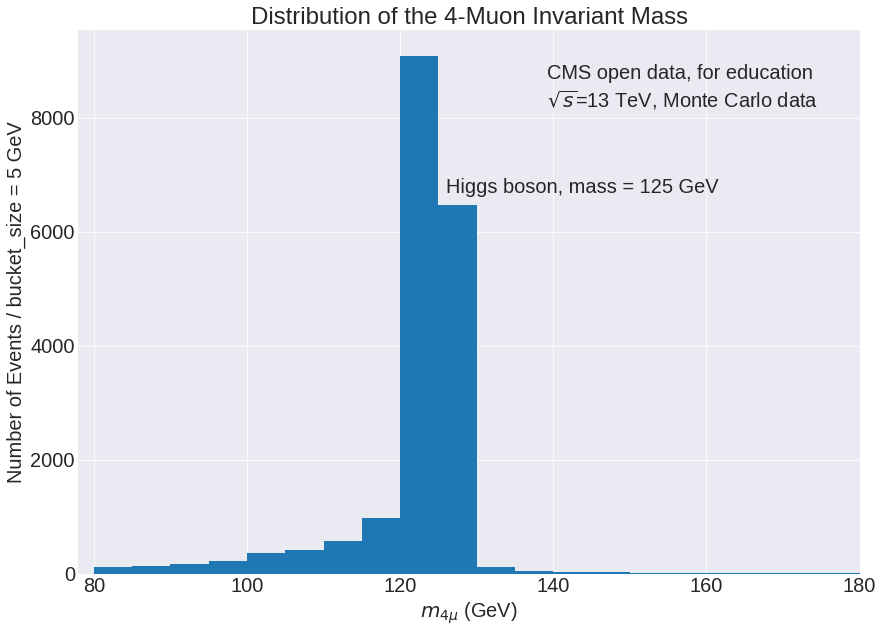

In [9]:
# This plots the data histogram with error bars

import matplotlib.pyplot as plt 

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# scatter plot
#ax.plot(x, y, marker='o', color='red', linewidth=0)
#ax.errorbar(x, y, err, fmt = 'ro')
# histogram with error bars
ax.bar(x, y, width = 5.0, capsize = 5, linewidth = 0.5, ecolor='blue', fill=True)

ax.set_xlim(min_val-2, max_val)

ax.set_xlabel('$m_{4\mu}$ (GeV)')
ax.set_ylabel('Number of Events / bucket_size = 5 GeV')
ax.set_title("Distribution of the 4-Muon Invariant Mass")

# Label for the Z ang Higgs spectrum peaks
txt_opts = {'horizontalalignment': 'left',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.47, 0.71, "Higgs boson, mass = 125 GeV", **txt_opts)

# Add energy and luminosity
plt.text(0.60, 0.92, "CMS open data, for education", **txt_opts)
plt.text(0.60, 0.87, '$\sqrt{s}$=13 TeV, Monte Carlo data', **txt_opts)

plt.show()

In [12]:
spark.stop()